In [5]:
import torch
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import librosa
import librosa.display

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import ArcticDataset, TIMITDataset
from tqdm.notebook import tqdm

print(torch.__version__)
print(torchaudio.__version__)

1.7.1+cu110
0.7.2


# CUDA

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset

In [7]:
vowel_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
                'IX', 'AXR', 'AH-H']

In [8]:
timit_dataset_train = TIMITDataset(usage='train', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                   phone_codes=vowel_labels)

timit_dataset_test = TIMITDataset(usage='test', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                  phone_codes=vowel_labels)

In [9]:
print(f'Length of the train dataset{len(timit_dataset_train)}')
print(f'Length of the test dataset{len(timit_dataset_test)}')

print(timit_dataset_train[0])

timit_waveform = timit_dataset_train[0].data
timit_framerate = timit_dataset_train[0].frame_rate
print(timit_waveform.shape)

Length of the train dataset57088
Length of the test dataset20793
AudioData(data=tensor([[-0.0038, -0.0046, -0.0045,  ...,  0.0000,  0.0000,  0.0000]]), label='IY', frame_rate=16000, sample_width=16)
torch.Size([1, 16000])


In [10]:
labels = sorted(list(set(datapoint.label for datapoint in timit_dataset_train)))
labels

['AA',
 'AE',
 'AH',
 'AO',
 'AW',
 'AX',
 'AXR',
 'AY',
 'EH',
 'ER',
 'EY',
 'IH',
 'IX',
 'IY',
 'OW',
 'OY',
 'UH',
 'UW',
 'UX']

In [11]:
def find_distribution(dataset):
    labels_dict = dict()
    for record in dataset:
        if record.label not in labels_dict:
            labels_dict[record.label] = 1
        else:
            labels_dict[record.label] += 1

    return labels_dict

In [12]:
train_labels_dict = find_distribution(timit_dataset_train)
test_labels_dict = find_distribution(timit_dataset_test)

In [13]:
train_labels_dict = {k: v for k, v in sorted(train_labels_dict.items(), key=lambda item: item[0])}
test_labels_dict = {k: v for k, v in sorted(test_labels_dict.items(), key=lambda item: item[0])}

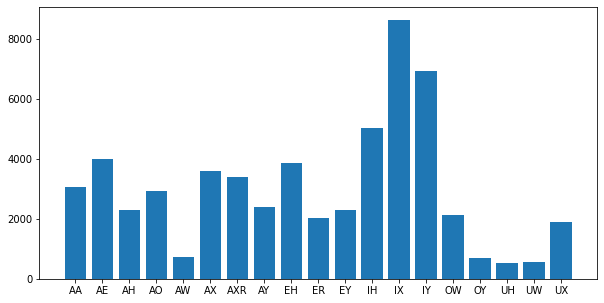

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(train_labels_dict.keys(), train_labels_dict.values(), width=0.8)
plt.show()

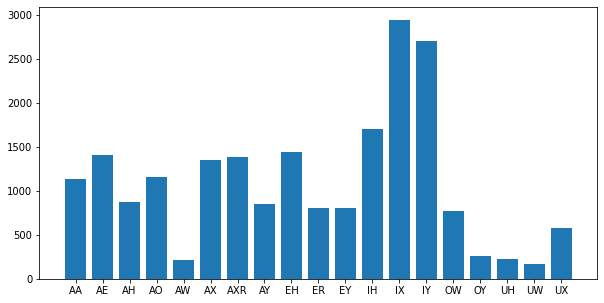

In [15]:
plt.figure(figsize=(10, 5))
plt.bar(test_labels_dict.keys(), test_labels_dict.values(), width=0.8)
plt.show()

# Transforms

IX


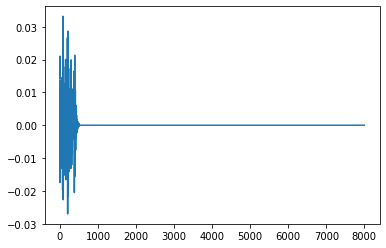

In [16]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)

item = 50
timit_waveform = timit_dataset_train[item].data
print(timit_dataset_train[item].label)

transformed = transform(timit_waveform)
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

# Formatting

In [17]:
def label_to_index(phone):
    return torch.tensor(labels.index(phone))


def index_to_label(index):
    return labels[index]


phone_start = "EY"
index = label_to_index(phone_start)
word_recovered = index_to_label(index)

print(phone_start, "-->", index, "-->", word_recovered)

EY --> tensor(10) --> EY


In [18]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(transformed.shape[0])


Feature batch shape: torch.Size([256, 1, 16000])
Labels batch shape: torch.Size([256])
1


# Models

## M11

In [19]:
from models.m_models import M11

model = M11(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_layers_2): MBlock(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_layers_3): MBlock(
    (layers): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

## Train and test

In [21]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

In [22]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)

        target = target.to(device)

        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(pbar_update)

        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        losses.append(loss.item())

In [23]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch, loader):
    model.eval()
    correct = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(correct, len(loader.dataset), (correct / len(loader.dataset)) * 100.0)

    return (correct / len(loader.dataset)) * 100.0


### TIMIT Corpus

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/57088 (0%)]	Loss: 2.994331
Train Epoch: 1 [5120/57088 (9%)]	Loss: 2.333726
Train Epoch: 1 [10240/57088 (18%)]	Loss: 2.281780
Train Epoch: 1 [15360/57088 (27%)]	Loss: 2.012595
Train Epoch: 1 [20480/57088 (36%)]	Loss: 1.994884
Train Epoch: 1 [25600/57088 (45%)]	Loss: 1.882167
Train Epoch: 1 [30720/57088 (54%)]	Loss: 1.907913
Train Epoch: 1 [35840/57088 (63%)]	Loss: 1.726439
Train Epoch: 1 [40960/57088 (72%)]	Loss: 1.724342
Train Epoch: 1 [46080/57088 (81%)]	Loss: 1.850510
Train Epoch: 1 [51200/57088 (90%)]	Loss: 1.851490
Train Epoch: 1 [56320/57088 (99%)]	Loss: 1.634712
7195 57088 12.603349215246636
On train: 13%
2781 20793 13.374693406434856
On test: 13%
Train Epoch: 2 [0/57088 (0%)]	Loss: 1.639674
Train Epoch: 2 [5120/57088 (9%)]	Loss: 1.758384
Train Epoch: 2 [10240/57088 (18%)]	Loss: 1.624032
Train Epoch: 2 [15360/57088 (27%)]	Loss: 1.667391
Train Epoch: 2 [20480/57088 (36%)]	Loss: 1.806405
Train Epoch: 2 [25600/57088 (45%)]	Loss: 1.683098
Train Epoch: 2 [30720/57088

Text(0.5, 1.0, 'training loss')

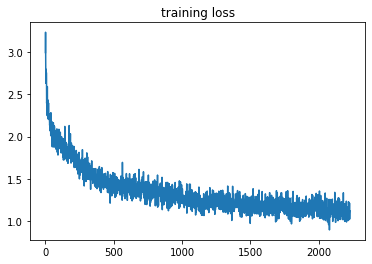

In [24]:
import matplotlib.pyplot as plt

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        print(f'On train: {test(model, epoch, train_loader):.0f}%')
        print(f'On test: {test(model, epoch, test_loader):.0f}%')
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

In [25]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


data, label, frame_rate, sample_width = timit_dataset_train[7]

print(f"Expected: {label}. Predicted: {predict(data)}.")

Expected: AA. Predicted: AA.
